# Create test data subset of OAE dataset for CarbonPlan

02/10/2024

Tom Nicholas

Notebook to create store2 in it's entirety for CarbonPlan.

We need to deal with a lot of data, but the problem is embarrassingly parallel (for each polygon).

The plan is to create one function that reads the relevant part of the netCDF dataset, grabs the relevant variables, does any vertical integrations necessary, creates a spatial pyramid out of the results, reshapes to the exact format CarbonPlan's viewer wants, then saves out to just one region of a new zarr store. Then this function can be parallelized using `dask.delayed`, until the whole job is done.

Variables that do not depend on `polygon_id` will need to be written in a separate `to_zarr` call once.

## Define task for each polygon

We eventually need a function which:
1. Accepts a polygon id as an input,
2. Opens all the netCDF files corresponding to that polygon into xarray
3. Combines the datasets into one
4. Does the vertical integration
5. Creates the spatial pyramid from the results
6. Writes the result into the correct `region` of a zarr store

Let's build these one-by-one and call them in one function at the end

In [1]:
!module list


Currently Loaded Modules:
  1) ncarenv/23.10       (S)   4) cuda/12.2.1     7) hdf5/1.12.2
  2) intel/2023.2.1            5) ucx/1.14.1      8) netcdf/4.9.2
  3) ncarcompilers/1.0.0       6) openmpi/4.1.6   9) texlive/20220321

  Where:
   S:  Module is Sticky, requires --force to unload or purge

 



In [2]:
store2_path = '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/CarbonPlan/perlmutter/store2.zarr'

### 1-3 (opening and combining)

In [4]:
from typing import List
import datetime
import re
import glob

import cftime
import xarray as xr
import numpy as np
import dask

In [5]:
# these are the only variables we actually need to calculate OAE efficiency
REQUIRED_DATA_VARIABLES = [
    # ALK (only at surface)
    'ALK',
    'ALK_ALT_CO2',
    # DIC (needs to be column integrated)
    'DIC',
    'DIC_ALT_CO2',
    # flux (only defined at surface)
    'FG_CO2',
    'FG_ALT_CO2',
    # surface pCO2
    'pCO2SURF',
    'pCO2SURF_ALT_CO2',
    # surface pH
    'PH',
    'PH_ALT_CO2',
    # surface Omega (we will need these but currently CO3 isn't in the compressed dataset, so can't calculate Omega)
    'CO3',
    'co3_sat_arag',
    'co3_sat_calc',
    # For vertical integration
    'dz',
    'TAREA',
    # dimension coords
    'polygon_id',
    'elapsed_time',
    'injection_month',
    # for reprojections
    'ULAT',
    'ULONG',
]

In [6]:
data_dir = '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/'

In [8]:
polygon_id = '000'
injection_month = '01'
single_simulation_glob = data_dir + f'{polygon_id}/{injection_month}/alk-forcing.{polygon_id}-1999-{injection_month}.pop.h.*.nc'
single_simulation_glob

'/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/000/01/alk-forcing.000-1999-01.pop.h.*.nc'

In [9]:
%%time
single_simulation = xr.open_mfdataset(
    single_simulation_glob,
    combine='by_coords', # can we do this with combine='nested'?
    data_vars='minimal',
    coords='minimal',
    compat='override',
    chunks={'time': 12, 'z_t': 60, 'nlat': 384, 'nlon': 320},  # open same way files are split (why does this not happen automatically??)
)

CPU times: user 15.5 s, sys: 2.02 s, total: 17.5 s
Wall time: 3min 11s


In [10]:
single_simulation

<xarray.Dataset> Size: 55GB
Dimensions:                     (polygon_id: 1, injection_date: 1,
                                 elapsed_time: 180, z_t: 60, nlat: 384,
                                 nlon: 320, d2: 2, z_t_150m: 15, z_w: 60,
                                 z_w_top: 60, z_w_bot: 60)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 3kB dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    time                        (injection_date, elapsed_time) object 1kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 1kB 0 days ......
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/34)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_calc                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_arag                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    ...                          ...
    ALK_ALT_CO2_zint_100m       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

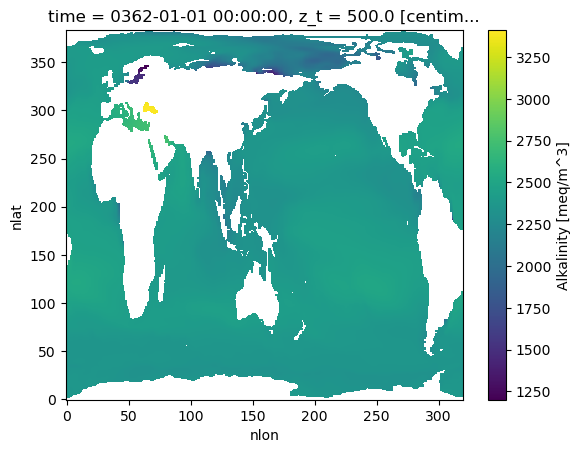

In [11]:
single_simulation['ALK'].isel(z_t=0, elapsed_time=-1).plot()

In [12]:
VARS_TO_DROP = [var_name for var_name in list(single_simulation.variables) if var_name not in REQUIRED_DATA_VARIABLES]

In [13]:
VARS_TO_DROP

['pH_3D',
 'CO3_ALT_CO2',
 'pH_3D_ALT_CO2',
 'CO2STAR',
 'DCO2STAR',
 'DpCO2',
 'ATM_CO2',
 'CO2STAR_ALT_CO2',
 'DCO2STAR_ALT_CO2',
 'DpCO2_ALT_CO2',
 'ALK_FLUX',
 'DIC_zint_100m',
 'DIC_ALT_CO2_zint_100m',
 'ALK_zint_100m',
 'STF_ALK',
 'ALK_ALT_CO2_zint_100m',
 'STF_ALK_ALT_CO2',
 'tend_zint_100m_DIC',
 'tend_zint_100m_DIC_ALT_CO2',
 'tend_zint_100m_ALK',
 'tend_zint_100m_ALK_ALT_CO2',
 'time_bound',
 'time',
 'z_t',
 'z_t_150m',
 'z_w',
 'z_w_top',
 'z_w_bot',
 'dzw',
 'TLONG',
 'TLAT',
 'KMT',
 'KMU',
 'REGION_MASK',
 'UAREA',
 'HU',
 'HT',
 'DXU',
 'DYU',
 'DXT',
 'DYT',
 'HTN',
 'HTE',
 'HUS',
 'HUW',
 'ANGLE',
 'ANGLET',
 'days_in_norm_year',
 'grav',
 'omega',
 'radius',
 'cp_sw',
 'sound',
 'vonkar',
 'cp_air',
 'rho_air',
 'rho_sw',
 'rho_fw',
 'stefan_boltzmann',
 'latent_heat_vapor',
 'latent_heat_fusion',
 'latent_heat_fusion_mks',
 'ocn_ref_salinity',
 'sea_ice_salinity',
 'T0_Kelvin',
 'salt_to_ppt',
 'ppt_to_salt',
 'mass_to_Sv',
 'heat_to_PW',
 'salt_to_Svppt',
 'salt_

In [14]:
single_simulation

<xarray.Dataset> Size: 55GB
Dimensions:                     (polygon_id: 1, injection_date: 1,
                                 elapsed_time: 180, z_t: 60, nlat: 384,
                                 nlon: 320, d2: 2, z_t_150m: 15, z_w: 60,
                                 z_w_top: 60, z_w_bot: 60)
Coordinates: (12/64)
    time_bound                  (injection_date, elapsed_time, d2) object 3kB dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    time                        (injection_date, elapsed_time) object 1kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  * z_t                         (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                    (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                         (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                     (z_w_top) float32 240B 0.0 1e+03 ... 5.25e+05
    ...                          ...
    sflux_factor                float64 8B ...
    nsurface_t                  float64 8B ...
    nsurface_u                  float64 8B ...
  * polygon_id                  (polygon_id) int64 8B 0
  * injection_date              (injection_date) object 8B 1999-01-01 00:00:00
  * elapsed_time                (elapsed_time) timedelta64[ns] 1kB 0 days ......
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/34)
    CO3                         (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D                       (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    CO3_ALT_CO2                 (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    pH_3D_ALT_CO2               (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_calc                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    co3_sat_arag                (polygon_id, injection_date, elapsed_time, z_t, nlat, nlon) float32 5GB dask.array<chunksize=(1, 1, 1, 60, 384, 320), meta=np.ndarray>
    ...                          ...
    ALK_ALT_CO2_zint_100m       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    STF_ALK_ALT_CO2             (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_DIC_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
    tend_zint_100m_ALK_ALT_CO2  (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB dask.array<chunksize=(1, 1, 1, 384, 320), meta=np.ndarray>
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [15]:
def open_and_load_data_for_one_simulation_without_dask(polygon_id: str, injection_month: str) -> xr.Dataset:

    files = sorted(glob.glob(data_dir + f'{polygon_id}/{injection_month}/alk-forcing.{polygon_id}-1999-{injection_month}.pop.h.*.nc'))

    datasets = [
        xr.open_dataset(filepath, chunks=None).drop_vars(VARS_TO_DROP)
        for filepath in files
    ]

    # we have to do vertical integrations before concatenating files else we will load all depths into memory
    for ds in datasets:
        for var_to_vertically_avg in ['DIC', 'DIC_ALT_CO2']:
            ds[var_to_vertically_avg] = integrate_column(ds[var_to_vertically_avg], ds['dz'] * 1e-3)

    # this concatenation is not lazy, so will now load the data
    # see https://github.com/pydata/xarray/issues/4628
    combined = xr.concat(
        [ds.isel(z_t=0) for ds in datasets],
        dim='elapsed_time',
        data_vars='minimal',
        coords='minimal',
        compat='override',
        join='override',
    )

    return combined

In [16]:
def integrate_column(var: xr.DataArray, depth_element: xr.DataArray) -> xr.DataArray:
    return (var * depth_element).sum(dim='z_t')

In [17]:
def open_data_for_one_simulation_without_dask(polygon_id: str, injection_month: str) -> xr.Dataset:

    ds = open_and_load_data_for_one_simulation_without_dask(polygon_id, injection_month)

    #ds = convert_polygon_id_coord_to_int(ds)

    #ds = expand_ensemble_dims(ds)

    elapsed_time_integer_months = xr.DataArray(np.arange(180), dims=['elapsed_time'], attrs={'units': 'months'})
    ds['elapsed_time'] = elapsed_time_integer_months.astype('int32')

    ds['injection_date'] = xr.DataArray(data=[int(injection_month)], dims='injection_date', attrs={'units': 'month of 1999'}).astype('int32')

    #return ds.swap_dims(time='elapsed_time')
    return ds

In [18]:
#depth_element = ds['dz'] * 1e-3

In [19]:
def open_data_for_one_simulation(polygon_id: str, injection_month: str) -> xr.Dataset:

    ds = xr.open_mfdataset(
        data_dir + f'{polygon_id}/{injection_month}/alk-forcing.{polygon_id}-1999-{injection_month}.pop.h.*.nc',
        preprocess=add_injection_time_coord,
        combine='by_coords', # can we do this with combine='nested'?
        drop_variables=VARS_TO_DROP,
        data_vars='minimal',
        coords='minimal',
        compat='override',
        join='override',
        chunks={'time': 12, 'z_t': 60, 'nlat': 384, 'nlon': 320},  # open same way files are split (why does this not happen automatically??)
    )

    ds = convert_polygon_id_coord_to_int(ds)

    ds = expand_ensemble_dims(ds)

    return convert_to_integer_time_coordinates(ds)

In [20]:
def list_files(polygon_id: str, injection_month: str) -> list[str]:
    return sorted(glob.glob(data_dir + f'{polygon_id}/{injection_month}/alk-forcing.{polygon_id}-1999-{injection_month}.pop.h.*.nc'))

In [21]:
list_files('000', '01')

['/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/000/01/alk-forcing.000-1999-01.pop.h.0347-01.nc',
 '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/000/01/alk-forcing.000-1999-01.pop.h.0347-02.nc',
 '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/000/01/alk-forcing.000-1999-01.pop.h.0347-03.nc',
 '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/000/01/alk-forcing.000-1999-01.pop.h.0347-04.nc',
 '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/000/01/alk-forcing.000-1999-01.pop.h.0347-05.nc',
 '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/000/01/alk-forcing.000-1999-01.pop.h.0347-06.nc',
 '/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/ResearchGrade/compressed4/000/01/alk-forcing.000-1999-01.pop.h.0347-07.nc',
 '/gla

In [43]:
%%time
#ds0 = open_and_load_data_for_one_simulation_without_dask('000', '01')

CPU times: user 3min 26s, sys: 12.4 s, total: 3min 38s
Wall time: 5min 35s


In [23]:
#ds0.close()

In [24]:
%%time
ds0 = open_data_for_one_simulation_without_dask('000', '01')

CPU times: user 3min 20s, sys: 14 s, total: 3min 34s
Wall time: 5min 44s


In [25]:
ds0

<xarray.Dataset> Size: 1GB
Dimensions:           (polygon_id: 1, injection_date: 1, elapsed_time: 180,
                       nlat: 384, nlon: 320)
Coordinates:
    dz                float32 4B 1e+03
    ULONG             (nlat, nlon) float64 983kB ...
    ULAT              (nlat, nlon) float64 983kB ...
    TAREA             (nlat, nlon) float64 983kB ...
  * polygon_id        (polygon_id) int64 8B 0
  * elapsed_time      (elapsed_time) int32 720B 0 1 2 3 4 ... 176 177 178 179
  * injection_date    (injection_date) int32 4B 1
Dimensions without coordinates: nlat, nlon
Data variables: (12/13)
    CO3               (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    co3_sat_calc      (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    co3_sat_arag      (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    pCO2SURF          (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    FG_CO2            (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    PH                (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    ...                ...
    FG_ALT_CO2        (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    PH_ALT_CO2        (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    DIC               (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    DIC_ALT_CO2       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    ALK               (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
    ALK_ALT_CO2       (polygon_id, injection_date, elapsed_time, nlat, nlon) float32 88MB ...
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [26]:
ds0.nbytes / 1e9

1.153106656

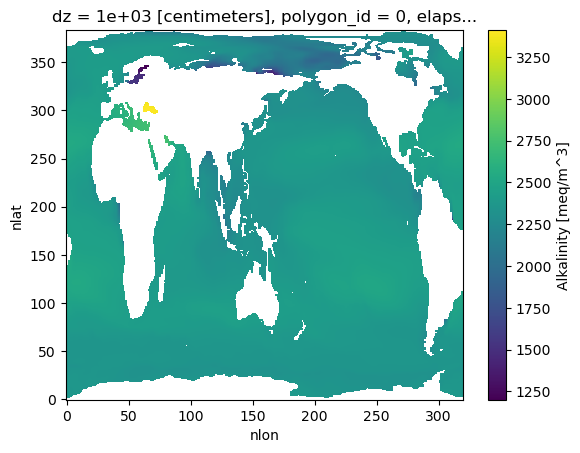

In [27]:
ds0['ALK'].isel(elapsed_time=-1).plot()

### 4 Vertical integration

### calculate differences (not experimental vs counterfactual)

We calculate what we actually will be plotting in advance so that the browser tool doesn't have to load both experimental and counterfactual in order to plot just the difference.

In [28]:
def calc_differences(ds: xr.Dataset) -> xr.Dataset:
    
    # difference = experimental - counterfactual
    ds['delta_ALK'] = ds['ALK'] - ds['ALK_ALT_CO2']
    ds['delta_DIC'] = ds['DIC'] - ds['DIC_ALT_CO2']
    ds['delta_PH'] = ds['PH'] - ds['PH_ALT_CO2']
    ds['delta_FG'] = ds['FG_CO2'] - ds['FG_ALT_CO2']
    ds['delta_pCO2SURF'] = ds['pCO2SURF'] - ds['pCO2SURF_ALT_CO2']
    
    return ds

In [29]:
differences = calc_differences(ds0)

### reshape time dimension

In [30]:
def reshape_into_month_year(ds: xr.Dataset) -> xr.Dataset:

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        reshaped = ds.assign_coords(
            month=xr.DataArray(data=np.concatenate([np.arange(1, 13)] * 15), dims='elapsed_time').astype('int32'), 
            year=xr.DataArray(data=np.repeat(np.arange(1, 16), 12), dims='elapsed_time').astype('int32'),
        ).swap_dims(
            elapsed_time='month',
        ).set_index(
            monthyear=("month", "year"),
        ).unstack(
            'monthyear',
        )

    return reshaped

In [31]:
reshaped = reshape_into_month_year(differences)

In [32]:
reshaped

<xarray.Dataset> Size: 2GB
Dimensions:           (month: 12, year: 15, polygon_id: 1, injection_date: 1,
                       nlat: 384, nlon: 320)
Coordinates:
  * month             (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * year              (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    dz                float32 4B 1e+03
    ULONG             (nlat, nlon) float64 983kB ...
    ULAT              (nlat, nlon) float64 983kB ...
    TAREA             (nlat, nlon) float64 983kB ...
  * polygon_id        (polygon_id) int64 8B 0
    elapsed_time      (month, year) int32 720B 0 12 24 36 48 ... 143 155 167 179
  * injection_date    (injection_date) int32 4B 1
Dimensions without coordinates: nlat, nlon
Data variables: (12/18)
    CO3               (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    co3_sat_calc      (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    co3_sat_arag      (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    pCO2SURF          (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    FG_CO2            (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    PH                (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    ...                ...
    ALK_ALT_CO2       (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    delta_ALK         (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    delta_DIC         (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    delta_PH          (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    delta_FG          (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
    delta_pCO2SURF    (polygon_id, injection_date, nlat, nlon, month, year) float32 88MB ...
Attributes:
    title:             smyle-fosi.North_Atlantic_basin.alk-forcing-North_Atla...
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-05-29 at 09:20:38.7
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

### concatenate into bands

In [33]:
def concatenate_into_bands(ds: xr.Dataset) -> xr.Dataset:
    bands_ds = xr.Dataset(coords=ds.coords)
    
    bands_ds['ALK'] = xr.concat(
        [ds['delta_ALK'], ds['ALK']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )
    bands_ds['DIC'] = xr.concat(
        [ds['delta_DIC'], ds['DIC']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )
    bands_ds['PH'] = xr.concat(
        [ds['delta_PH'], ds['PH']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )
    bands_ds['FG'] = xr.concat(
        [ds['delta_FG'], ds['FG_CO2']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )
    bands_ds['pCO2SURF'] = xr.concat(
        [ds['delta_pCO2SURF'], ds['pCO2SURF']],
        dim=xr.DataArray(name='band', data=['delta', 'experimental'], dims='band'),
    )

    # notice we chunk along the band dimension
    return bands_ds.isel(z_t=0, missing_dims='warn')#.chunk(band=1, nlat=384, nlon=320)

In [34]:
bands = concatenate_into_bands(reshaped)

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xarray/core/utils.py:836: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'month': 12, 'year': 15, 'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'band': 2})
  warnings.warn(


In [35]:
bands

<xarray.Dataset> Size: 888MB
Dimensions:         (month: 12, year: 15, nlat: 384, nlon: 320, polygon_id: 1,
                     injection_date: 1, band: 2)
Coordinates:
  * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    dz              float32 4B 1e+03
    ULONG           (nlat, nlon) float64 983kB ...
    ULAT            (nlat, nlon) float64 983kB ...
    TAREA           (nlat, nlon) float64 983kB ...
  * polygon_id      (polygon_id) int64 8B 0
    elapsed_time    (month, year) int32 720B 0 12 24 36 48 ... 143 155 167 179
  * injection_date  (injection_date) int32 4B 1
  * band            (band) <U12 96B 'delta' 'experimental'
Dimensions without coordinates: nlat, nlon
Data variables:
    ALK             (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...
    DIC             (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...
    PH              (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...
    FG              (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...
    pCO2SURF        (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...

### 5 (create pyramid)

### First pre-generate the weights

In [36]:
VERSION = 2
LEVELS = 2

In [37]:
# make a reprojected (EPSG:3857) pyramid
ds_to_regrid = bands.rio.write_crs('EPSG:4326')

In [39]:
from ndpyramid.regrid import generate_weights_pyramid

weights_pyramid = generate_weights_pyramid(
    ds_to_regrid,
    levels=LEVELS,
    projection='web-mercator',
)

In [40]:
weights_pyramid

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       levels:         2
│       regrid_method:  bilinear
├── DataTree('0')
│       Dimensions:  (n_s: 48580)
│       Dimensions without coordinates: n_s
│       Data variables:
│           S        (n_s) float64 389kB 0.2995 0.03018 0.6089 ... 0.3277 0.1154 0.4779
│           col      (n_s) int32 194kB 115055 115056 115375 115376 ... 194 195 514 515
│           row      (n_s) int32 194kB 1 1 1 1 2 2 ... 14335 14336 14336 14336 14336
│       Attributes:
│           n_in:     122880
│           n_out:    16384
└── DataTree('1')
        Dimensions:  (n_s: 194592)
        Dimensions without coordinates: n_s
        Data variables:
            S        (n_s) float64 2MB 0.07861 0.2126 0.1913 ... 0.2834 0.1946 0.1472
            col      (n_s) int32 778kB 115054 115055 115374 115375 ... 195 196 515 516
            row      (n_s) int32 778kB 1 1 1 1 2 2 ... 57343 57344 57344 57344 57344
        Attributes:
            n_in:     122880
            n_out:    65536

In [41]:
!pwd

/glade/u/home/tnicholas/oae_dataset/CarbonPlan


In [37]:
weights_pyramid_path = '/glade/u/home/tnicholas/oae_dataset/CarbonPlan/weights_pyramid.zarr'

In [43]:
#!rm -rf /glade/u/home/tnicholas/oae_dataset/CarbonPlan/weights_pyramid.zarr

In [44]:
weights_pyramid.to_zarr(weights_pyramid_path)

### Now we can apply them without importing ESMF

In [38]:
from datatree import DataTree

In [39]:
from datatree import open_datatree

In [40]:
PIXELS_PER_TILE = 128

In [41]:
def pyramidify_sparse(ds: xr.Dataset) -> DataTree:

    from ndpyramid.regrid import pyramid_regrid
    
    # make a reprojected (EPSG:3857) pyramid
    ds_to_reproject = ds.rio.write_crs('EPSG:4326')

    # load the weights pyramid from disk
    weights_pyramid = open_datatree(weights_pyramid_path, engine='zarr').compute()
    
    # this function has been altered to use sparse matrix regridding instead of calling xESMF
    regridded_pyramid = pyramid_regrid(
        ds_to_reproject,
        weights_pyramid=weights_pyramid,
        levels=LEVELS,
        projection='web-mercator',
        pixels_per_tile=PIXELS_PER_TILE,
    )

    # TODO not sure this function is actually properly implemented on datatree...
    weights_pyramid.close()
    
    return regridded_pyramid

In [42]:
# def pyramidify(ds: xr.Dataset, weights_pyramid: DataTree = None) -> DataTree:

#     # make a reprojected (EPSG:3857) pyramid
#     ds_to_reproject = ds.rio.write_crs('EPSG:4326')

#     # this function has been altered so as not to call .chunk on the output
#     return pyramid_regrid(
#         ds_to_reproject, 
#         levels=LEVELS,
#         #weights_pyramid=weights_pyramid,
#         projection='web-mercator',
#         pixels_per_tile=PIXELS_PER_TILE,
#         #regridder_kws={'ignore_degenerate': True}
#         #use_xr_regrid
#     )

In [43]:
%%time
pyramid = pyramidify_sparse(bands)

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/glade/work/tnicholas/conda-envs/dev3.10/lib

CPU times: user 5.58 s, sys: 804 ms, total: 6.38 s
Wall time: 17.4 s


In [44]:
pyramid

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       multiscales:  [{'datasets': [{'path': '0', 'level': 0, 'crs': 'EPSG:3857'...
│       title:        multiscale data pyramid
│       version:      0.1.0.post14+gaf6f2fb.d20240522
├── DataTree('0')
│       Dimensions:         (band: 2, polygon_id: 1, injection_date: 1, month: 12,
│                            year: 15, y: 128, x: 128)
│       Coordinates:
│         * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
│         * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
│           dz              float32 4B 1e+03
│         * polygon_id      (polygon_id) int32 4B 0
│           elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
│         * injection_date  (injection_date) int32 4B 1
│         * band            (band) <U12 96B 'delta' 'experimental'
│           spatial_ref     int32 4B 0
│         * x               (x) float32 512B -1.988e+07 -1.957e+07 ... 1.988e+07
│         * y               (y) float32 512B 1.988e+07 1.957e+07 ... -1.988e+07
│       Data variables:
│           ALK             (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
│           DIC             (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
│           PH              (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
│           FG              (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
│           pCO2SURF        (band, polygon_id, injection_date, month, year, y, x) float32 24MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
│       Attributes:
│           regrid_method:  bilinear
│           multiscales:    [{'datasets': [{'path': '.', 'level': 0, 'crs': 'EPSG:385...
└── DataTree('1')
        Dimensions:         (band: 2, polygon_id: 1, injection_date: 1, month: 12,
                             year: 15, y: 256, x: 256)
        Coordinates:
          * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
          * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
            dz              float32 4B 1e+03
          * polygon_id      (polygon_id) int32 4B 0
            elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
          * injection_date  (injection_date) int32 4B 1
          * band            (band) <U12 96B 'delta' 'experimental'
            spatial_ref     int32 4B 0
          * x               (x) float32 1kB -1.996e+07 -1.98e+07 ... 1.98e+07 1.996e+07
          * y               (y) float32 1kB 1.996e+07 1.98e+07 ... -1.98e+07 -1.996e+07
        Data variables:
            ALK             (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
            DIC             (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
            PH              (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
            FG              (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
            pCO2SURF        (band, polygon_id, injection_date, month, year, y, x) float32 94MB dask.array<chunksize=(2, 1, 1, 12, 15, 128, 128), meta=np.ndarray>
        Attributes:
            regrid_method:  bilinear
            multiscales:    [{'datasets': [{'path': '.', 'level': 1, 'crs': 'EPSG:385...

In [45]:
pyramid.nbytes / 1e6

589.828952

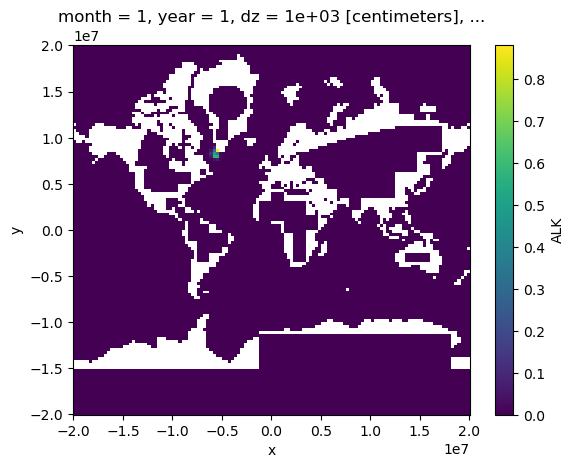

In [46]:
pyramid['0']['ALK'].sel(band='delta').isel(month=0, year=0, polygon_id=0, injection_date=0).plot()

In [47]:
#pyramid['0']['ALK'].sel(band='experimental').isel(month=0, year=0, polygon_id=0, injection_date=0).plot()

### 6 (write into target store)

In [48]:
pyramid['0']['ALK'].dims

('band', 'polygon_id', 'injection_date', 'month', 'year', 'y', 'x')

In [49]:
pyramid['0']['ALK'].chunks

((2,), (1,), (1,), (12,), (15,), (128,), (128,))

In [50]:
#pyramid['0']['ALK'].chunksizes

TODO: Raise a bug report on xarray about this, it shouldn't have raised that error.

In [51]:
pyramid['0']['ALK'].encoding

{'dtype': 'float32',
 'compressor': Zlib(level=1),
 '_FillValue': 9.969209968386869e+36}

In [52]:
def set_compression_encoding(dt: DataTree) -> DataTree:
    from zarr import Zlib

    compressor = Zlib(level=1)
    
    for node in dt.subtree:
        for name, var in node.variables.items():
            
            # avoid using NaN as a fill value, and avoid overflow errors in encoding
            if np.issubdtype(var.dtype, np.integer):
                node[name].encoding = {'compressor': compressor, '_FillValue': 2_147_483_647}
            elif var.dtype == np.dtype('float32'):
                node[name].encoding = {'compressor': compressor, '_FillValue': 9.969209968386869e+36}
            else:
                node[name].encoding = {'compressor': compressor}

    return dt

### all together

In [53]:
#from dask.distributed import print as distributed_print
import os

In [54]:
bands

<xarray.Dataset> Size: 888MB
Dimensions:         (month: 12, year: 15, nlat: 384, nlon: 320, polygon_id: 1,
                     injection_date: 1, band: 2)
Coordinates:
  * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    dz              float32 4B 1e+03
    ULONG           (nlat, nlon) float64 983kB ...
    ULAT            (nlat, nlon) float64 983kB ...
    TAREA           (nlat, nlon) float64 983kB ...
  * polygon_id      (polygon_id) int64 8B 0
    elapsed_time    (month, year) int32 720B 0 12 24 36 48 ... 143 155 167 179
  * injection_date  (injection_date) int32 4B 1
  * band            (band) <U12 96B 'delta' 'experimental'
Dimensions without coordinates: nlat, nlon
Data variables:
    ALK             (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...
    DIC             (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...
    PH              (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...
    FG              (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...
    pCO2SURF        (band, polygon_id, injection_date, nlat, nlon, month, year) float32 177MB ...

In [56]:
@dask.delayed
def process_polygon(polygon_id: str, injection_date: str) -> dask.delayed:
    ds = open_data_for_one_simulation_without_dask(polygon_id, injection_date)
    #ds = open_data_for_one_simulation(polygon_id, injection_date)

    # this has already been done in the open_without_dask step
    # # vertically average DIC
    # depth_element = ds['dz'] * 1e-3
    # ds['DIC'] = integrate_column(ds['DIC'], depth_element)
    # ds['DIC_ALT_CO2'] = integrate_column(ds['DIC'], depth_element)

    differences = calc_differences(ds)
    
    reshaped = reshape_into_month_year(differences)

    bands = concatenate_into_bands(reshaped)

    #distributed_print(bands)
    
    pyramid = pyramidify_sparse(
        bands#.drop_vars(['ULONG', 'ULAT'], errors='ignore')
    )#, weights_pyramid=weights_dt)
    
    dt_to_save_computed = pyramid#.compute()#scheduler='single-threaded')

    encoded_dt = set_compression_encoding(
        dt_to_save_computed.drop_vars(['spatial_ref'])
    )

    #distributed_print(encoded_dt)
    
    #return ds
    return encoded_dt.drop_vars(['dz'], errors='warn').to_zarr(
        store=store2_path,
        region='auto',
        mode='r+',
    )

    # datatree_to_zarr_ignore_empty_root_group(
    #     encoded_dt, 
    #     '/glade/u/home/tnicholas/oae_dataset/CarbonPlan/store2.zarr',
    #     region='auto', 
    #     mode='r+',
    # )

## Define structure of target store

We need to create a zarr store with empty arrays for the outputs we want to write in sequentially later.

In [80]:
non_ensemble_dt = pyramid.drop_vars(
    ['ALK', 'DIC', 'FG', 'PH', 'pCO2SURF'],
)#.coords.to_dataset()
#non_ensemble_ds = ds0.isel(z_t=0).coords.to_dataset()

In [81]:
non_ensemble_dt

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       multiscales:  [{'datasets': [{'path': '0', 'level': 0, 'crs': 'EPSG:3857'...
│       title:        multiscale data pyramid
│       version:      0.1.0.post14+gaf6f2fb.d20240522
├── DataTree('0')
│       Dimensions:         (month: 12, year: 15, polygon_id: 1, injection_date: 1,
│                            band: 2, x: 128, y: 128)
│       Coordinates:
│         * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
│         * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
│           dz              float32 4B 1e+03
│         * polygon_id      (polygon_id) int32 4B 0
│           elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
│         * injection_date  (injection_date) int32 4B 1
│         * band            (band) <U12 96B 'delta' 'experimental'
│           spatial_ref     int32 4B 0
│         * x               (x) float32 512B -1.988e+07 -1.957e+07 ... 1.988e+07
│         * y               (y) float32 512B 1.988e+07 1.957e+07 ... -1.988e+07
│       Data variables:
│           *empty*
│       Attributes:
│           regrid_method:  bilinear
│           multiscales:    [{'datasets': [{'path': '.', 'level': 0, 'crs': 'EPSG:385...
└── DataTree('1')
        Dimensions:         (month: 12, year: 15, polygon_id: 1, injection_date: 1,
                             band: 2, x: 256, y: 256)
        Coordinates:
          * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
          * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
            dz              float32 4B 1e+03
          * polygon_id      (polygon_id) int32 4B 0
            elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
          * injection_date  (injection_date) int32 4B 1
          * band            (band) <U12 96B 'delta' 'experimental'
            spatial_ref     int32 4B 0
          * x               (x) float32 1kB -1.996e+07 -1.98e+07 ... 1.98e+07 1.996e+07
          * y               (y) float32 1kB 1.996e+07 1.98e+07 ... -1.98e+07 -1.996e+07
        Data variables:
            *empty*
        Attributes:
            regrid_method:  bilinear
            multiscales:    [{'datasets': [{'path': '.', 'level': 1, 'crs': 'EPSG:385...

In [82]:
non_ensemble_vars_plus_ensemble_dim_coords_dt = non_ensemble_dt.copy()

In [83]:
# coordinates are loaded into memory so let's just create them complete already for ensemble dims
non_ensemble_vars_plus_ensemble_dim_coords_dt['0']['polygon_id'] = xr.DataArray(np.arange(690), dims='polygon_id').astype('int32')
non_ensemble_vars_plus_ensemble_dim_coords_dt['0']['injection_date'] = xr.DataArray([1, 4, 7, 10], dims='injection_date').astype('int32')
non_ensemble_vars_plus_ensemble_dim_coords_dt['1']['polygon_id'] = xr.DataArray(np.arange(690), dims='polygon_id').astype('int32')
non_ensemble_vars_plus_ensemble_dim_coords_dt['1']['injection_date'] = xr.DataArray([1, 4, 7, 10], dims='injection_date').astype('int32')

In [84]:
non_ensemble_vars_plus_ensemble_dim_coords_dt

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       multiscales:  [{'datasets': [{'path': '0', 'level': 0, 'crs': 'EPSG:3857'...
│       title:        multiscale data pyramid
│       version:      0.1.0.post14+gaf6f2fb.d20240522
├── DataTree('0')
│       Dimensions:         (month: 12, year: 15, polygon_id: 690, injection_date: 4,
│                            band: 2, x: 128, y: 128)
│       Coordinates:
│         * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
│         * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
│           dz              float32 4B 1e+03
│         * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
│           elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
│         * injection_date  (injection_date) int32 16B 1 4 7 10
│         * band            (band) <U12 96B 'delta' 'experimental'
│           spatial_ref     int32 4B 0
│         * x               (x) float32 512B -1.988e+07 -1.957e+07 ... 1.988e+07
│         * y               (y) float32 512B 1.988e+07 1.957e+07 ... -1.988e+07
│       Data variables:
│           *empty*
│       Attributes:
│           regrid_method:  bilinear
│           multiscales:    [{'datasets': [{'path': '.', 'level': 0, 'crs': 'EPSG:385...
└── DataTree('1')
        Dimensions:         (month: 12, year: 15, polygon_id: 690, injection_date: 4,
                             band: 2, x: 256, y: 256)
        Coordinates:
          * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
          * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
            dz              float32 4B 1e+03
          * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
            elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
          * injection_date  (injection_date) int32 16B 1 4 7 10
          * band            (band) <U12 96B 'delta' 'experimental'
            spatial_ref     int32 4B 0
          * x               (x) float32 1kB -1.996e+07 -1.98e+07 ... 1.98e+07 1.996e+07
          * y               (y) float32 1kB 1.996e+07 1.98e+07 ... -1.98e+07 -1.996e+07
        Data variables:
            *empty*
        Attributes:
            regrid_method:  bilinear
            multiscales:    [{'datasets': [{'path': '.', 'level': 1, 'crs': 'EPSG:385...

### Write non-ensemble variables

Includes polygon_mask_id

In [85]:
store2_path

'/glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/CarbonPlan/perlmutter/store2.zarr'

In [86]:
set_compression_encoding(
    non_ensemble_vars_plus_ensemble_dim_coords_dt.drop_vars(['spatial_ref'])
).to_zarr(store=store2_path, mode='w', compute=True)

[########################################] | 100% Completed | 102.94 ms
[########################################] | 100% Completed | 102.69 ms


In [87]:
!ls /glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/CarbonPlan/perlmutter/store2.zarr/0

band  dz  elapsed_time	injection_date	month  polygon_id  x  y  year


### Write empty placeholders for ensemble variables

now add empty versions of the ensemble variables

In [88]:
store1b_chunks_encoding_per_variable = {
    'OAE_efficiency':  {'chunks': {'polygon_id': 1, 'injection_date': 1, 'elapsed_time': 180}},          # polygon_id: 1 injection_date: 1 elapsed_time: 180
    #'ALK_zint_100m':   {'chunks': (1, 384, 320)},        # polygon_id: 1 nlat: 384 nlon: 320
    'polygon_id':      {'chunks': {'polygon_id': 1}},                 # polygon_id: 1
    'injection_date':  {'chunks': {'injection_date': 1}},                 # injection_date: 1
    'elapsed_time':    {'chunks': {'elapsed_time': 180}}, 
}
    # elapsed_time: 180
    #'time':            {'chunks': (1, 180)},             # injection_date: 1 elapsed_time: 180

In [89]:
chunks_ensemble_var = {
    'polygon_id': 1,
    'band': 1,
    'injection_date': 1,
    'month': 1,
    'year': 15,
    'y': PIXELS_PER_TILE,
    'x': PIXELS_PER_TILE,
}

store2_chunks_encoding_per_variable = {
    'ALK': {'chunks': chunks_ensemble_var},
    'DIC': {'chunks': chunks_ensemble_var},
    'FG': {'chunks': chunks_ensemble_var},
    'PH': {'chunks': chunks_ensemble_var},
    'pCO2SURF': {'chunks': chunks_ensemble_var},
    # can't write these out yet but placeholders are useful
    'Omega_calc': {'chunks': chunks_ensemble_var},
    'Omega_arag': {'chunks': chunks_ensemble_var},
}

In [90]:
import dask.array as dsa

def create_empty_target_variable(var_name: str, x_y_size, dtype) -> xr.DataArray:
    sizes_all_dims = {
        'polygon_id': 690, 
        'band': 2,
        'injection_date': 4,
        'month': 12,
        'year': 15,
        'y': x_y_size,
        'x': x_y_size,
    }
    
    var_chunks = store2_chunks_encoding_per_variable[var_name]['chunks']
    var_dims = list(var_chunks.keys())
    var_sizes = {d: s for d, s in sizes_all_dims.items() if d in var_dims}
    var_shape = tuple(var_sizes.values())
    ordered_var_dims = list(var_sizes.keys())
    
    da_target = xr.DataArray(
        dsa.empty(
            shape=var_shape,
            chunks=var_chunks,
            dtype=dtype,
        ),
        name=var_name,
        dims=ordered_var_dims,
    )
    return da_target.chunk(**var_chunks)

In [91]:
target_dt = non_ensemble_vars_plus_ensemble_dim_coords_dt.copy()

# placeholder dask array for each ensemble variable
for var_name in ['ALK', 'DIC', 'FG', 'PH', 'pCO2SURF', 'Omega_calc', 'Omega_arag']:
    
    new_empty_var = create_empty_target_variable(var_name, x_y_size=128, dtype="f4")
    target_dt['0'][var_name] = new_empty_var

    new_empty_var = create_empty_target_variable(var_name, x_y_size=256, dtype="f4")
    target_dt['1'][var_name] = new_empty_var

In [92]:
set_compression_encoding(target_dt)['0']['ALK'].encoding

{'compressor': Zlib(level=1), '_FillValue': 9.969209968386869e+36}

In [93]:
from datatree.io import _create_empty_zarr_group

# have to do this manually because compute=False is not implemented in DataTree.to_zarr
def datatree_to_zarr_compute_false(dt: DataTree, store, mode) -> None:
    for node in dt.subtree:
        ds = node.ds
        #print(ds)
        
        group_path = node.path
        #print(f"group_path={group_path}")
        
        if ds is None:
            _create_empty_zarr_group(store, group_path, mode)
        else:
            ds.to_zarr(
                store,
                group=group_path,
                mode=mode,
                #encoding={},
                consolidated=False,
                compute=False,
                #**kwargs,
            )

In [94]:
target_dt['0']['ALK'].encoding

{'compressor': Zlib(level=1), '_FillValue': 9.969209968386869e+36}

In [95]:
target_dt

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       multiscales:  [{'datasets': [{'path': '0', 'level': 0, 'crs': 'EPSG:3857'...
│       title:        multiscale data pyramid
│       version:      0.1.0.post14+gaf6f2fb.d20240522
├── DataTree('0')
│       Dimensions:         (month: 12, year: 15, polygon_id: 690, injection_date: 4,
│                            band: 2, x: 128, y: 128)
│       Coordinates:
│         * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
│         * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
│           dz              float32 4B 1e+03
│         * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
│           elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
│         * injection_date  (injection_date) int32 16B 1 4 7 10
│         * band            (band) <U12 96B 'delta' 'experimental'
│           spatial_ref     int32 4B 0
│         * x               (x) float32 512B -1.988e+07 -1.957e+07 ... 1.988e+07
│         * y               (y) float32 512B 1.988e+07 1.957e+07 ... -1.988e+07
│       Data variables:
│           ALK             (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           DIC             (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           FG              (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           PH              (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           pCO2SURF        (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           Omega_calc      (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│           Omega_arag      (polygon_id, band, injection_date, month, year, y, x) float32 65GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
│       Attributes:
│           regrid_method:  bilinear
│           multiscales:    [{'datasets': [{'path': '.', 'level': 0, 'crs': 'EPSG:385...
└── DataTree('1')
        Dimensions:         (month: 12, year: 15, polygon_id: 690, injection_date: 4,
                             band: 2, x: 256, y: 256)
        Coordinates:
          * month           (month) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
          * year            (year) int32 60B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
            dz              float32 4B 1e+03
          * polygon_id      (polygon_id) int32 3kB 0 1 2 3 4 5 ... 685 686 687 688 689
            elapsed_time    (month, year) int32 720B dask.array<chunksize=(12, 15), meta=np.ndarray>
          * injection_date  (injection_date) int32 16B 1 4 7 10
          * band            (band) <U12 96B 'delta' 'experimental'
            spatial_ref     int32 4B 0
          * x               (x) float32 1kB -1.996e+07 -1.98e+07 ... 1.98e+07 1.996e+07
          * y               (y) float32 1kB 1.996e+07 1.98e+07 ... -1.98e+07 -1.996e+07
        Data variables:
            ALK             (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            DIC             (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            FG              (polygon_id, band, injection_date, month, year, y, x) float32 260GB dask.array<chunksize=(1, 1, 1, 1, 15, 128, 128), meta=np.ndarray>
            PH              (polygon_id, band, injection_date, month, year, y, x) float32 260GB d

In [96]:
datatree_to_zarr_compute_false(set_compression_encoding(
    target_dt.drop_vars(['spatial_ref'])
), store=store2_path, mode='w')

In [97]:
!ls /glade/derecho/scratch/tnicholas/projects/OAE-Global-Efficiency/CarbonPlan/perlmutter/store2.zarr/0

ALK   DIC  elapsed_time  injection_date  Omega_arag  pCO2SURF  polygon_id  y
band  dz   FG		 month		 Omega_calc  PH        x	   year


### Try it for one polygon

In [75]:
delayed_000_01 = process_polygon('000', '01')

In [76]:
delayed_000_01

Delayed('process_polygon-fa19c33b-bc76-42f9-b1c9-778b04cdb9b9')

In [77]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [78]:
# https://github.com/pangeo-data/xESMF/issues/141
# Need scheduler='single-threaded' to avoid this ^

In [79]:
%%time
dask.compute(delayed_000_01, scheduler='single-threaded')

[                                        ] | 0% Completed | 232.48 ss

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xarray/core/utils.py:836: UserWarning: Dimensions {'z_t'} do not exist. Expected one or more of FrozenMappingWarningOnValuesAccess({'month': 12, 'year': 15, 'nlat': 384, 'nlon': 320, 'polygon_id': 1, 'injection_date': 1, 'band': 2})
  warnings.warn(


[                                        ] | 0% Completed | 233.80 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[                                        ] | 0% Completed | 234.10 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[                                        ] | 0% Completed | 234.41 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[                                        ] | 0% Completed | 234.71 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[                                        ] | 0% Completed | 234.92 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[                                        ] | 0% Completed | 235.22 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[                                        ] | 0% Completed | 235.73 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[                                        ] | 0% Completed | 236.14 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[                                        ] | 0% Completed | 236.54 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[                                        ] | 0% Completed | 237.05 s

/glade/work/tnicholas/conda-envs/dev3.10/lib/python3.10/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


[########################################] | 100% Completed | 247.20 s
CPU times: user 3min 37s, sys: 10.4 s, total: 3min 48s
Wall time: 4min 7s


(None,)

In [85]:
ds00001 = open_data_for_one_simulation('000', '01')

# vertically average DIC
depth_element = ds00001['dz'] * 1e-3
ds00001['DIC'] = integrate_column(ds00001['DIC'], depth_element)
ds00001['DIC_ALT_CO2'] = integrate_column(ds00001['DIC'], depth_element)

reshaped = reshape_into_month_year(ds00001)

bands = concatenate_into_bands(reshaped)

pyramid = pyramidify(bands)

/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing w

[                                        ] | 0% Completed | 101.84 msms
[########################################] | 100% Completed | 202.51 ms
[########################################] | 100% Completed | 101.59 ms
[########################################] | 100% Completed | 201.40 ms
[########################################] | 100% Completed | 101.06 ms
[########################################] | 100% Completed | 101.88 ms
[########################################] | 100% Completed | 101.68 ms
[########################################] | 100% Completed | 202.15 ms
[########################################] | 100% Completed | 101.60 ms
[########################################] | 100% Completed | 201.31 ms
[########################################] | 100% Completed | 102.15 ms
[########################################] | 100% Completed | 201.51 ms


In [86]:
dt_to_save_computed = pyramid.compute(scheduler='single-threaded')

[########################################] | 100% Completed | 204.51 s
[########################################] | 100% Completed | 204.61 s
[########################################] | 100% Completed | 123.63 s
[########################################] | 100% Completed | 123.73 s


In [90]:
transposed_dt_to_save_computed = dt_to_save_computed.transpose(
    "polygon_id", "band", "injection_date", "month", "year", "y", "x", ...
)

In [91]:
transposed_dt_to_save_computed

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       multiscales:  [{'datasets': [{'path': '0', 'pixels_per_tile': 128, 'crs':...
│       title:        multiscale data pyramid
│       version:      0.1.0.post14+gaf6f2fb
├── DataTree('0')
│       Dimensions:         (band: 2, polygon_id: 1, injection_date: 1, month: 12,
│                            year: 15, y: 128, x: 128, z_t_150m: 15, z_w: 60,
│                            z_w_top: 60, z_w_bot: 60)
│       Coordinates: (12/15)
│         * month           (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
│         * year            (year) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
│           z_t             float32 500.0
│         * z_t_150m        (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
│         * z_w             (z_w) float32 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
│         * z_w_top         (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
│           ...              ...
│           time            (month, year) object 0347-02-01 00:00:00 ... 0362-01-01 0...
│           elapsed_time    (month, year) int32 0 12 24 36 48 60 ... 131 143 155 167 179
│         * band            (band) <U14 'experiment' 'counterfactual'
│           spatial_ref     int64 0
│         * x               (x) float32 -1.988e+07 -1.957e+07 ... 1.957e+07 1.988e+07
│         * y               (y) float32 1.988e+07 1.957e+07 ... -1.957e+07 -1.988e+07
│       Data variables:
│           ALK             (polygon_id, band, injection_date, month, year, y, x) float32 ...
│           DIC             (polygon_id, band, injection_date, month, year, y, x) float32 ...
│           PH              (polygon_id, band, injection_date, month, year, y, x) float32 ...
│           FG              (polygon_id, band, injection_date, month, year, y, x) float32 ...
│       Attributes:
│           regrid_method:  bilinear
└── DataTree('1')
        Dimensions:         (band: 2, polygon_id: 1, injection_date: 1, month: 12,
                             year: 15, y: 256, x: 256, z_t_150m: 15, z_w: 60,
                             z_w_top: 60, z_w_bot: 60)
        Coordinates: (12/15)
          * month           (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
          * year            (year) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
            z_t             float32 500.0
          * z_t_150m        (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
          * z_w             (z_w) float32 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
          * z_w_top         (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
            ...              ...
            time            (month, year) object 0347-02-01 00:00:00 ... 0362-01-01 0...
            elapsed_time    (month, year) int32 0 12 24 36 48 60 ... 131 143 155 167 179
          * band            (band) <U14 'experiment' 'counterfactual'
            spatial_ref     int64 0
          * x               (x) float32 -1.996e+07 -1.98e+07 ... 1.98e+07 1.996e+07
          * y               (y) float32 1.996e+07 1.98e+07 ... -1.98e+07 -1.996e+07
        Data variables:
            ALK             (polygon_id, band, injection_date, month, year, y, x) float32 ...
            DIC             (polygon_id, band, injection_date, month, year, y, x) float32 ...
            PH              (polygon_id, band, injection_date, month, year, y, x) float32 ...
            FG              (polygon_id, band, injection_date, month, year, y, x) float32 ...
        Attributes:
            regrid_method:  bilinear

In [92]:
transposed_dt_to_save_computed['0']['ALK'].encoding

{'compressor': Zlib(level=1), '_FillValue': 9.969209968386869e+36}

In [93]:
set_compression_encoding(
    transposed_dt_to_save_computed.drop_vars(['z_t', 'spatial_ref'])
).to_zarr(store='store2.zarr', region='auto', mode='r+')

In [115]:
ds00104 = open_data_for_one_simulation('001', '04')

# vertically average DIC
depth_element = ds00104['dz'] * 1e-3
ds00104['DIC'] = integrate_column(ds00104['DIC'], depth_element)
ds00104['DIC_ALT_CO2'] = integrate_column(ds00104['DIC'], depth_element)

reshaped = reshape_into_month_year(ds00104)

bands = concatenate_into_bands(reshaped)

pyramid = pyramidify(bands)

/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/glade/u/home/tnicholas/code/xarray/xarray/core/indexing.py:1446: PerformanceWarning: Slicing w

[########################################] | 100% Completed | 101.21 ms
[########################################] | 100% Completed | 202.10 ms
[########################################] | 100% Completed | 101.21 ms
[########################################] | 100% Completed | 202.20 ms
[########################################] | 100% Completed | 100.91 ms
[########################################] | 100% Completed | 101.16 ms
[                                        ] | 0% Completed | 101.31 msms
[########################################] | 100% Completed | 202.64 ms
[########################################] | 100% Completed | 101.18 ms
[########################################] | 100% Completed | 202.43 ms
[########################################] | 100% Completed | 101.30 ms
[########################################] | 100% Completed | 102.69 ms


In [116]:
dt_to_save_computed = pyramid.compute(scheduler='single-threaded')

[########################################] | 100% Completed | 164.04 s
[########################################] | 100% Completed | 164.11 s
[########################################] | 100% Completed | 153.57 s
[########################################] | 100% Completed | 153.62 s


In [119]:
set_compression_encoding(
    dt_to_save_computed.drop_vars(['z_t', 'spatial_ref'])
).to_zarr(store='store2.zarr', region='auto', mode='r+')

In [120]:
from datatree import open_datatree

In [121]:
roundtrip = open_datatree('store2.zarr', engine='zarr')

In [122]:
roundtrip

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       multiscales:  [{'datasets': [{'crs': 'EPSG:3857', 'path': '0', 'pixels_pe...
│       title:        multiscale data pyramid
│       version:      0.1.0.post14+gaf6f2fb
├── DataTree('0')
│       Dimensions:         (month: 12, year: 15, band: 2, polygon_id: 690,
│                            injection_date: 4, x: 128, y: 128, z_t_150m: 15, z_w: 60,
│                            z_w_bot: 60, z_w_top: 60)
│       Coordinates: (12/15)
│         * band            (band) <U14 'experiment' 'counterfactual'
│           elapsed_time    (month, year) int32 ...
│         * injection_date  (injection_date) int32 1 4 7 10
│         * month           (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
│         * polygon_id      (polygon_id) int32 0 1 2 3 4 5 6 ... 684 685 686 687 688 689
│           spatial_ref     int64 ...
│           ...              ...
│         * year            (year) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
│           z_t             float32 ...
│         * z_t_150m        (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
│         * z_w             (z_w) float32 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
│         * z_w_bot         (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
│         * z_w_top         (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
│       Data variables:
│           ALK             (month, year, band, polygon_id, injection_date, x, y) float64 ...
│           DIC             (month, year, band, polygon_id, injection_date, x, y) float64 ...
│           FG              (month, year, band, polygon_id, injection_date, x, y) float64 ...
│           PH              (month, year, band, polygon_id, injection_date, x, y) float64 ...
│       Attributes:
│           regrid_method:  bilinear
└── DataTree('1')
        Dimensions:         (month: 12, year: 15, band: 2, polygon_id: 690,
                             injection_date: 4, x: 256, y: 256, z_t_150m: 15, z_w: 60,
                             z_w_bot: 60, z_w_top: 60)
        Coordinates: (12/15)
          * band            (band) <U14 'experiment' 'counterfactual'
            elapsed_time    (month, year) int32 ...
          * injection_date  (injection_date) int32 1 4 7 10
          * month           (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
          * polygon_id      (polygon_id) int32 0 1 2 3 4 5 6 ... 684 685 686 687 688 689
            spatial_ref     int64 ...
            ...              ...
          * year            (year) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
            z_t             float32 ...
          * z_t_150m        (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
          * z_w             (z_w) float32 0.0 1e+03 2e+03 ... 4.75e+05 5e+05 5.25e+05
          * z_w_bot         (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.25e+05 5.5e+05
          * z_w_top         (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
        Data variables:
            ALK             (month, year, band, polygon_id, injection_date, x, y) float64 ...
            DIC             (month, year, band, polygon_id, injection_date, x, y) float64 ...
            FG              (month, year, band, polygon_id, injection_date, x, y) float64 ...
            PH              (month, year, band, polygon_id, injection_date, x, y) float64 ...
        Attributes:
            regrid_method:  bilinear

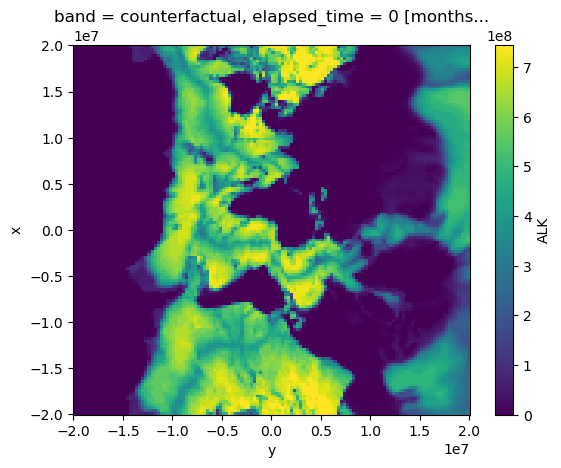

In [129]:
roundtrip['0']['ALK'].isel(polygon_id=1, injection_date=1, band=1, year=0, month=0).plot()

In [130]:
roundtrip.close()

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       multiscales:  [{'datasets': [{'crs': 'EPSG:3857', 'path': '0', 'pixels_pe...
│       title:        multiscale data pyramid
│       version:      0.1.0.post14+gaf6f2fb
├── DataTree('0')
└── DataTree('1')

## Perform tasks for all polygons

Looks good, so let's do all the rest.

### Set up all OAE efficiency calculations

In [98]:
def polygon_ids_as_strings(s: slice) -> list[str]:
    """Generate list of all polygon ids of the form '001' in this slice."""
    values = np.arange(s.start, s.stop)

    def left_pad_with_zeros(number, width):
        return f"{number:0{width}}"
        
    return [left_pad_with_zeros(val, 3) for val in values]

In [99]:
690 * 4

2760

In [100]:
all_tasks = [
    process_polygon(polygon_id, injection_month)
    for polygon_id in polygon_ids_as_strings(slice(0, 690))
    for injection_month in ['01', '04', '07', '10']
]

In [101]:
len(all_tasks)

2760

In [102]:
all_tasks[0:10]

[Delayed('process_polygon-09a83d22-50b4-4937-b311-5c2448b09ca6'),
 Delayed('process_polygon-8792c2c1-ecdd-43d8-a196-416a01717196'),
 Delayed('process_polygon-dec3fa5a-2188-438c-874e-e3e366ca4af1'),
 Delayed('process_polygon-7940abf2-096e-4bf7-8912-840a318fe0ab'),
 Delayed('process_polygon-a1ba5182-8e2b-4d7f-9edd-d6e7b250c324'),
 Delayed('process_polygon-0eae604e-1692-4cc3-888f-b5ee7bd7c131'),
 Delayed('process_polygon-55227f25-51e5-4e9d-ad20-15683c546152'),
 Delayed('process_polygon-546c071e-2629-4d9f-b5ea-c0073910d7ef'),
 Delayed('process_polygon-16387d97-ca5a-43a4-a6c4-f2b12f4d7b21'),
 Delayed('process_polygon-ebc4e3e2-d659-48c2-b0e8-7a828fa2374b')]

### Scale up

In [103]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [104]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'carbonplan-store2',
    cores = 1,
    memory = '16GiB',
    processes = 1,
    local_directory = '/local_scratch/pbs.$PBS_JOBID/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=16GB',
    queue = 'casper',
    walltime = '24:00:00',
    interface = 'ext',
    job_extra_directives=['-V'],
)

2024-10-06 18:17:29,499 - distributed.scheduler - ERROR - Task process_polygon-38f30b58-9e32-407b-b827-42a60d4c72d3 marked as failed because 4 workers died while trying to run it


In [105]:
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.112:41303,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [106]:
# Create the client to load the Dashboard
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.112:41303,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/tnicholas/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [107]:
print(cluster.job_script())

#!/usr/bin/env bash

#PBS -N carbonplan-store2
#PBS -q casper
#PBS -A P93300070
#PBS -l select=1:ncpus=1:mem=16GB
#PBS -l walltime=24:00:00
#PBS -V

/glade/work/tnicholas/conda-envs/dev3.10/bin/python -m distributed.cli.dask_worker tcp://128.117.208.112:41303 --name dummy-name --nthreads 1 --memory-limit 16.00GiB --nanny --death-timeout 60 --local-directory /local_scratch/pbs.$PBS_JOBID/dask/spill --interface ext



In [135]:
cluster.scale(0)

In [108]:
cluster.scale(8)

In [110]:
cluster.scale(100)

In [109]:
# Block progress until workers have spawned (typically only in demos and benchmarks!)
client.wait_for_workers(100)

KeyboardInterrupt: 

In [111]:
len(all_tasks)

2760

In [109]:
dask.persist(all_tasks[:8], retries=0)

([Delayed('process_polygon-09a83d22-50b4-4937-b311-5c2448b09ca6'),
  Delayed('process_polygon-8792c2c1-ecdd-43d8-a196-416a01717196'),
  Delayed('process_polygon-dec3fa5a-2188-438c-874e-e3e366ca4af1'),
  Delayed('process_polygon-7940abf2-096e-4bf7-8912-840a318fe0ab'),
  Delayed('process_polygon-a1ba5182-8e2b-4d7f-9edd-d6e7b250c324'),
  Delayed('process_polygon-0eae604e-1692-4cc3-888f-b5ee7bd7c131'),
  Delayed('process_polygon-55227f25-51e5-4e9d-ad20-15683c546152'),
  Delayed('process_polygon-546c071e-2629-4d9f-b5ea-c0073910d7ef')],)

In [133]:
all_tasks[7]

Delayed('process_polygon-5eb009d8-9451-47ba-9c16-6f017ed16744')

launched 8 tasks at 12:20pm on 8 workers

finished by 12:34pm

In [111]:
dask.persist(all_tasks[8:100], retries=1)

([Delayed('process_polygon-16387d97-ca5a-43a4-a6c4-f2b12f4d7b21'),
  Delayed('process_polygon-ebc4e3e2-d659-48c2-b0e8-7a828fa2374b'),
  Delayed('process_polygon-1d8336dd-ee1c-4146-b04e-80d469e1ebac'),
  Delayed('process_polygon-ac560f15-df25-4dc6-8fe4-561d1239ccda'),
  Delayed('process_polygon-96fa77ad-d86c-478a-b61a-520cb5f7655e'),
  Delayed('process_polygon-dc62963c-68b3-46f7-8834-0dab99ddd5fa'),
  Delayed('process_polygon-58ff7afd-f4b3-4542-bb76-565cd79ebf8f'),
  Delayed('process_polygon-9c5ae6a3-b9b4-49e0-aea6-03887e191d31'),
  Delayed('process_polygon-249c4982-329f-4082-b36e-8a0d7f4470ef'),
  Delayed('process_polygon-cbe68cb6-9407-4580-8e41-1a65372f7e58'),
  Delayed('process_polygon-56268522-4b68-4916-bfec-ba1eb84f68aa'),
  Delayed('process_polygon-e9ac2a28-430e-426a-93da-6486cd15e035'),
  Delayed('process_polygon-21682e15-e0dd-46ab-ba6a-c5e4c84cc27d'),
  Delayed('process_polygon-bb4bd16f-d57e-4697-97b5-ea79c5184bc8'),
  Delayed('process_polygon-de709097-5399-454e-a6af-29277e67f6e

launched 92 tasks at 12:34pm with ~100 workers

finished by ?

In [112]:
block_size = 100

In [113]:
list(range(100, 2760, 100))

[100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700]

In [114]:
from dask.distributed import wait

In [115]:
already_complete = 100
n_all_tasks = len(all_tasks)
batch_size = 100
for i in range(already_complete, n_all_tasks, batch_size):
    # Extract the current batch
    batch = all_tasks[i:i+batch_size]
    
    # Submit the batch to the cluster
    futures = client.persist(batch, retries=1)
    
    # Wait for the batch to complete
    wait(futures)

In [116]:
# Do the last 60

# Extract the current batch
batch = all_tasks[2700:2760]

# Submit the batch to the cluster
futures = client.persist(batch, retries=1)

# Wait for the batch to complete
wait(futures)

DoneAndNotDoneFutures(done={<Future: finished, type: NoneType, key: process_polygon-b4c366da-0298-4ba7-8707-8a3f9bfde725>, <Future: finished, type: NoneType, key: process_polygon-38f30b58-9e32-407b-b827-42a60d4c72d3>, <Future: finished, type: NoneType, key: process_polygon-77f19d8c-5d1c-44d4-a3ba-34b2f0914d45>, <Future: finished, type: NoneType, key: process_polygon-88875b92-ca7d-424d-a80e-2365ea284313>, <Future: finished, type: NoneType, key: process_polygon-634ef546-77ce-4a12-9ae3-0bc6d317f450>, <Future: finished, type: NoneType, key: process_polygon-acaacd5f-838c-42cb-a480-072a87f72028>, <Future: finished, type: NoneType, key: process_polygon-99174a47-366c-4c55-bc5f-d62b7f2ce56a>, <Future: finished, type: NoneType, key: process_polygon-9429f404-46e9-400b-b146-88eeb6a31452>, <Future: finished, type: NoneType, key: process_polygon-38999c35-f7fe-4913-82c8-07385f39b61f>, <Future: finished, type: NoneType, key: process_polygon-40b00ffa-7033-4d05-af2e-424c69c1a178>, <Future: finished, typ

In [93]:
futures = client.futures

In [97]:
list(futures.values())[0].status

'pending'

In [98]:
client.cancel(futures.values())

In [117]:
cluster.close()

In [118]:
client.close()